In [34]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.stats import norm
import requests_cache
import matplotlib.pyplot as plt


# Implementation of Black-Scholes formula in Python
# Define variables 
# r is the risk-free rate
# S is the current stock price
# K is the option strike price
# T is the time to maturity
# sigma is the volatility of the stock

def blackScholes(r, S, K, T, sigma, type="c"):
    "Calculate BS price of call/put"
    d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    try:
        if type == "c":
            price = S*norm.cdf(d1, 0, 1) - K*np.exp(-r*T)*norm.cdf(d2, 0, 1)
        elif type == "p":
            price = K*np.exp(-r*T)*norm.cdf(-d2, 0, 1) - S*norm.cdf(-d1, 0, 1)
        return price
    except:
        print("Please confirm option type, either 'c' for Call or 'p' for Put!")

def delta_calc(r, S, K, T, sigma, type="c"):
    "Calculate delta of an option"
    d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
    try:
        if type == "c":
            delta_calc = norm.cdf(d1, 0, 1)
        elif type == "p":
            delta_calc = -norm.cdf(-d1, 0, 1)
        return delta_calc
    except:
        print("Please confirm option type, either 'c' for Call or 'p' for Put!")

def theta_calc(r, S, K, T, sigma, type="c"):
    "Calculate BS price of call/put"
    d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    try:
        if type == "c":
            theta_calc = -S*norm.pdf(d1, 0, 1)*sigma/(2*np.sqrt(T)) - r*K*np.exp(-r*T)*norm.cdf(d2, 0, 1)
        elif type == "p":
            theta_calc = -S*norm.pdf(d1, 0, 1)*sigma/(2*np.sqrt(T)) + r*K*np.exp(-r*T)*norm.cdf(-d2, 0, 1)
        return theta_calc/365
    except:
        print("Please confirm option type, either 'c' for Call or 'p' for Put!")



def get_option_data(stock_symbol='JPM', session=None):
    # Load data
    stock = yf.Ticker(stock_symbol, session=session)
    # Get stock option information
    all_call_data = []
    all_put_data = []
    option_dates = stock.options
    for date in option_dates:
        option_data = stock.option_chain(date)
        # print(type(option_data.calls))
        
        call_data = option_data.calls
        put_data = option_data.puts
        
        call_data['date'] = date
        put_data['date'] = date
        call_data['stock_symbol'] = stock_symbol
        put_data['stock_symbol'] = stock_symbol

        call_data['Option Income'] = call_data['lastPrice'] * 100
        call_data['Break Even'] = call_data['strike'] + call_data['lastPrice']
        call_data['Total Income'] = call_data['Option Income'] + (call_data['strike'] * 100)

        put_data['Option Income'] = put_data['lastPrice'] * 100
        put_data['Break Even'] = put_data['strike'] - put_data['lastPrice']
        put_data['Total Income'] = put_data['Option Income'] + (put_data['strike'] * 100)

        all_call_data.append(option_data.calls)
        all_put_data.append(option_data.puts)


    # print(all_call_data[0])

    return all_call_data, all_put_data


def get_stock_price_history(stock_symbol='JPM', session=None):
    # Load data
    stock = yf.Ticker(stock_symbol, session=session) 
    # Get stock price history
    stock_data = stock.history(period='3mo')
    return stock_data

In [28]:
session = requests_cache.CachedSession('yfinance.cache')
session.headers['User-agent'] = 'my-program/1.0'
price_data = get_stock_price_history('JPM', session=session)
options_call_data, options_put_data = get_option_data('JPM', session=session)
price_data['Daily_Returns'] = (price_data['Close'] / price_data['Close'].shift(1)) - 1

In [31]:
daily_std = price_data['Daily_Returns'].std()
sigma = daily_std * np.sqrt(252)
r = 0.01
s = price_data['Close'].iloc[-1]

# # print(options_put_data[0])
for i in range(len(options_put_data)):
    t = (pd.to_datetime(options_put_data[i]['date'][0]) - pd.to_datetime('today')).days/365
    options_put_data[i]['BS Price'] = blackScholes(r=r, S=s, K = options_put_data[i]['strike'], T=t, sigma=sigma, type='p')
    options_put_data[i]['Delta'] = delta_calc(r=r, S=s, K = options_put_data[i]['strike'], T=t, sigma=sigma, type='p')
    options_put_data[i]['Theta'] = theta_calc(r=r, S=s, K = options_put_data[i]['strike'], T=t, sigma=sigma, type='p')

for i in range(len(options_call_data)):
    t = (pd.to_datetime(options_call_data[i]['date'][0]) - pd.to_datetime('today')).days/365
    options_call_data[i]['BS Price'] = blackScholes(r=r, S=s, K = options_call_data[i]['strike'], T=t, sigma=sigma, type='c')
    options_call_data[i]['Delta'] = delta_calc(r=r, S=s, K = options_call_data[i]['strike'], T=t, sigma=sigma, type='c')
    options_call_data[i]['Theta'] = theta_calc(r=r, S=s, K = options_call_data[i]['strike'], T=t, sigma=sigma, type='c')

In [42]:
price_data.iloc[-1]['Close'] * 1.2

230.75799865722658

In [32]:
options_put_data[0]

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,...,contractSize,currency,date,stock_symbol,Option Income,Break Even,Total Income,BS Price,Delta,Theta
0,JPM240726P00115000,2024-07-18 14:30:04+00:00,115.0,0.11,0.00,0.25,0.000000,0.000000,1.0,1,...,REGULAR,USD,2024-07-26,JPM,11.0,114.89,11511.0,3.226835e-175,-2.027430e-174,-3.200511e-173
1,JPM240726P00145000,2024-07-15 16:53:59+00:00,145.0,0.01,0.00,0.02,0.000000,0.000000,8.0,24,...,REGULAR,USD,2024-07-26,JPM,1.0,144.99,14501.0,7.260687e-68,-2.813944e-67,-2.735144e-66
2,JPM240726P00150000,2024-06-07 19:53:29+00:00,150.0,0.15,0.00,0.13,0.000000,0.000000,2.0,2,...,REGULAR,USD,2024-07-26,JPM,15.0,149.85,15015.0,2.013009e-56,-7.095035e-56,-6.267887e-55
3,JPM240726P00155000,2024-06-24 13:35:02+00:00,155.0,0.13,0.00,0.03,0.000000,0.000000,4.0,8,...,REGULAR,USD,2024-07-26,JPM,13.0,154.87,15513.0,2.192063e-46,-6.983086e-46,-5.571189e-45
4,JPM240726P00160000,2024-07-16 13:36:28+00:00,160.0,0.03,0.00,0.03,0.000000,0.000000,5.0,30,...,REGULAR,USD,2024-07-26,JPM,3.0,159.97,16003.0,1.244998e-37,-3.558288e-37,-2.544201e-36
5,JPM240726P00165000,2024-07-19 19:58:40+00:00,165.0,0.04,0.00,0.25,0.010000,33.333336,1213.0,65,...,REGULAR,USD,2024-07-26,JPM,4.0,164.96,16504.0,4.753633e-30,-1.208101e-29,-7.669736e-29
6,JPM240726P00170000,2024-07-19 16:16:36+00:00,170.0,0.03,0.00,0.04,0.020000,200.000000,250.0,554,...,REGULAR,USD,2024-07-26,JPM,3.0,169.97,17003.0,1.533223e-23,-3.427272e-23,-1.909839e-22
7,JPM240726P00175000,2024-07-19 18:38:04+00:00,175.0,0.24,0.01,0.04,0.230000,2300.000000,4.0,368,...,REGULAR,USD,2024-07-26,JPM,24.0,174.76,17524.0,5.137102e-18,-9.963985e-18,-4.803474e-17
8,JPM240726P00180000,2024-07-19 16:12:44+00:00,180.0,0.02,0.01,0.05,0.000000,0.000000,2.0,130,...,REGULAR,USD,2024-07-26,JPM,2.0,179.98,18002.0,2.159654e-13,-3.572716e-13,-1.462377e-12
9,JPM240726P00182500,2024-07-19 19:00:10+00:00,182.5,0.04,0.04,0.05,0.000000,0.000000,219.0,119,...,REGULAR,USD,2024-07-26,JPM,4.0,182.46,18254.0,2.148170e-11,-3.255904e-11,-1.217173e-10


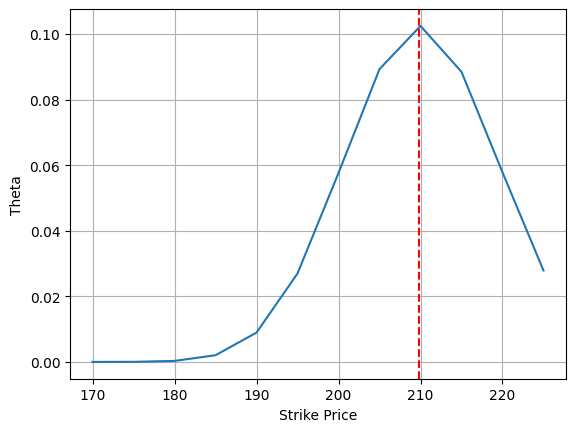

In [50]:
lower_bound = price_data.iloc[-1]['Close'] * 0.8
upper_bound = price_data.iloc[-1]['Close'] * 1.2

# Plot only the options that are within the range of 20% of the current stock price
filtered_data = options_put_data[2][(options_put_data[2]['strike'] > lower_bound) & (options_put_data[2]['strike'] < upper_bound)]

plt.plot(filtered_data['strike'], (filtered_data['Theta']* -1))
# Vertical line at the current stock price
plt.axvline(price_data.iloc[-1]['Close'], color='r', linestyle='--')
plt.xlabel('Strike Price')
plt.ylabel('Theta')
plt.grid()
plt.show()